In [2]:
import flatsurf
from flatsurf import *
from flatsurf.geometry.similarity_surface_generators import *
from flatsurf.geometry.polygon import polygons
from sage.geometry.hyperbolic_space.hyperbolic_model import HyperbolicGeodesic
from sage.geometry.hyperbolic_space.hyperbolic_model import moebius_transform
from sage.plot.plot3d.shapes import *
from sage.plot.plot3d.shapes2 import Line
import time


class Vertex:
    r'''
    A vertex object can be defined by either a complex number or a pair of
    coordinates of norm <= 1. They represent a point in the UHP and Klein model
    respectively. The 'get_field' option will tell the program to generate a
    number field for the coordinate in the Klein model.
    '''
    def __init__(self, v, get_field = False):
        self._v_km = None
        self._v_uhp = None
        if get_field:
            self._v_km = generate_field(v)
        else:
            if type(v) == tuple:
                self._v_km = v
            else:
                self._v_uhp = v
                self._v_km = point_UHP_to_KM(v)
        
    def dist(self, other):
        r'''
        Returns the Euclidean distance from one point to another in KM.
        '''
        return sqrt((self.x() - other.x())**2 + (self.y() - other.y())**2)
            
    def __rmul__(self, other):
        r'''
        This defines coordinate-wise multiplication.
        '''
        assert type(other) == Vertex
        return Vertex((other * self.km()[0], other * self.km()[1]))
        
    def __add__(self, other):
        r'''
        This defines coordinate-wise addition.
        '''
        return Vertex((self.x() + other.x(), self.y() + other.y()))
    
    def __sub__(self, other):
        r'''
        This defines coordinate-wise subtraction.
        '''
        return Vertex((self.x() - other.x(), self.y() - other.y()))
    
    def __neg__(self):
        r'''
        This defines the negative of a vertex object.
        '''
        return Vertex((-self.x(), -self.y()))
    
    
    def __eq__(self, other):
        r'''
        For two vertex objects to be equal, they must represent the same point in KM or UHP.
        '''
        return (AA(self.x()), AA(self.y())) == (AA(other.x()), AA(other.y()))
    
    @cached_method
    def __hash__(self):
        r'''
        The hash is defined by the sum of the hashes of the x and y-coordinates in KM.
        '''
        return hash(AA(self.x())) + hash(AA(self.y()))
    def km(self, approx = False):
        if approx:
            return (float(self.x()), float(self.y()))
        return self._v_km
    def uhp(self, approx = False):
        if self._v_uhp:
            if approx:
                return self._v_uhp.n()
            return self._v_uhp
        else:
            self._v_uhp = point_KM_to_UHP(self.km())
            if approx:
                return self._v_uhp.n()
            return self._v_uhp
    
    def x(self):
        return self.km()[0]
    def y(self):
        return self.km()[1]
    def norm(self):
        r'''
        Returns the Euclidean distance from (0, 0) to self.
        '''
        return self.km()[0]**2 + self.km()[1]**2
    def plot(self, model = "UHP", axes = True, xmin = -2, xmax = 2, ymin = 0, ymax = 2, figsize = 30):
        try:
            if model == "UHP":
                g = HyperbolicPlane().UHP().get_point(self.uhp(approx = True), color = "red", size = 50)
            else:
                g = HyperbolicPlane().KM().get_point(self.km(approx = True), color = "red", size = 50)
            return g.show()
        except AttributeError:
            pass


class Edge:
    r'''
    An edge object is represented by a pair of vertex objects. However, if
    e1 = Edge(v1, v2) and
    e2 = Edge(v2, v1).
    We want them to be the same under ==.
    '''
    
    
    def __init__(self, v1, v2):
        self._end_points = [v1, v2]
    
    def e(self):
        return self._end_points
    def e_km(self, approx = False):
        
        return self._end_points[0].km(approx = approx), self._end_points[1].km(approx = approx)
#         return self._end_points[0].km(), self._end_points[1].km()
    def e_uhp(self, approx = False):
        r'''
        The approx parameter is there for plotting.
        '''
        return self._end_points[0].uhp(approx = approx), self._end_points[1].uhp(approx = approx)
    
    
    def __eq__(self, other):
        return set(self.e()) == set(other.e())

    @cached_method
    def __hash__(self):
        r'''
        The hash of an edge is the sum of the hashes of its vertices.
        '''
        return hash(self._end_points[0]) + hash(self._end_points[1])
    
    def plot(self, model = "UHP", axes = True, xmin = -2, xmax = 2,
             ymin = 0, ymax = 2, figsize = 30, color = "blue"):
        try:
            if model == "UHP":
                g = HyperbolicPlane().UHP().get_geodesic(self.e_uhp(approx = True)[0],\
                                                         self.e_uhp(approx = True)[1], color = color)
                return g.plot(axes = axes, xmin = xmin, xmax = xmax,\
                                  ymin = ymin, ymax = ymax, figsize = figsize)
            else:
                g = HyperbolicPlane().KM().get_geodesic(self.e_km(approx = True)[0],\
                                                        self.e_km(approx = True)[1], color = color)
                return g.plot(axes = axes, xmin = -1, xmax = 1, ymin = -1, ymax = 1, figsize = figsize)
        except AttributeError:
            return None

        
        
@cached_function
def get_intersection(v1, v2, w1, w2):
    r'''
    Given four vertex objects, return the intersection of
    two lines defined by v1, v2 and w1, w2, respectively.
    '''
    x1, y1 = v1.km()
    x2, y2 = v2.km()
    x3, y3 = w1.km()
    x4, y4 = w2.km()
    D = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    Px = (x1*y2-y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4)
    Py = (x1*y2-y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4)
    return Vertex((Px/D, Py/D), get_field = True)

@cached_function
def tri_center(v1, v2, v3):
    r'''
    Given three vertices, define a mobius map by
    v1 |-> v2,
    v2 |-> v3, and
    v3 |-> v1.
    Return the vertex object defined by the fixed point of
    this mobius map such that the imaginary component is positive.
    '''
    
    center_of_0_1_inf = 1/2 + sqrt(3)/2 * I
    L = [v1.uhp(), v2.uhp(), v3.uhp()]
    if v2.uhp() == oo:
        L = [v2.uhp(), v3.uhp(), v1.uhp()]
    elif v3.uhp() == oo:
        L = [v3.uhp(), v1.uhp(), v2.uhp()]
    if oo in L: #we know L[0] == oo
        f(x) = ((x-1)*L[2] + L[1]) / x
    else:
        f(x) = (L[0] * ((x-1)*L[2] + L[1]) - x*L[1]*L[2]) / (x*L[0] - (x-1)*L[1] - L[2])
    return Vertex(f(center_of_0_1_inf), get_field = True)
        
        
        
        
        
@cached_function
def generate_field(v):
    r'''
    Given a complex number (UHP) or a pair of coordinates (KM),
    return a pair of coordinates in KM where the coordinates
    are in a number field.
    '''
    if type(v) != tuple:
        v = point_UHP_to_KM(v)
    tup = number_field_elements_from_algebraics([v[0], v[1]], embedded=True)
    field = tup[0]
    return (field(v[0]), field(v[1]))
        
@cached_function
def point_UHP_to_KM(z, approx = False):
    if approx:
        z = z.n()
    if z == oo:
        return (0, 1)
    pairx = 2 * z.real() / (z.real()**2 + z.imag()**2 + 1)
    pairy = (z.real()**2 + z.imag()**2 - 1) / (z.real()**2 + z.imag()**2 + 1)
    return (pairx, pairy)

@cached_function
def point_KM_to_UHP(pair, approx = False):
    if approx:
        x, y = float(pair[0]), float(pair[1])
        temp = 1 - x**2 - y**2
        if temp <= 0:
            return x / (1-y)
        else:
            return x / (1-y) + I*(sqrt(temp) / (1-y))
    else:
        x, y  = pair[0], pair[1]
    if (x, y) == (0, 1):
        return oo
    return QQbar(x) / QQbar(1-y) + QQbar(I)*QQbar(sqrt(AA(1 - x**2 - y**2)) / QQbar(1-y))

@cached_function
def point_KM_to_float_UHP(pair):
    x, y = pair[0], pair[1]
    if (x, y) == (0, 1):
        return oo
    x, y = float(pair[0]), float(pair[1])
    temp = 1 - x**2 - y**2
    if temp <= 0:
        return x / (1-y)
    else:
        return x / (1-y) + I*(sqrt(temp) / (1-y))

@cached_function
def get_edge_geo_ineq(s, x, no_geo = False): # x is of the form ((p0, e0), (p1, e1))
    r'''
    Given a surface s, and gluing data x, return the inequality
    defined in Bowman's paper and the geodesic (edge object).
    In particular, the inequality is a line in the KM (Bowman p.8, eq.2),
    and the geodesic returned is the line in the UHP.
    
    Note that the geodesic is not needed when we try to build an
    IDR from a translation surface, hence the paramater 'no_geo'.
    '''
    # Below gives a polygon named 'new_polygon' defined by the four points
    # obtained from the gluing data x.
    P = Polygons(s.base_ring())
    p0_label = x[0][0]
    p1_label = x[1][0]
    e0 = x[0][1]
    e1 = x[1][1]
    p0 = s.polygon(p0_label)
    g = s.edge_transformation(p1_label, e1)
    p1 = g(s.polygon(p1_label))
    p0_moved = P(edges=[p0.edge((i + e0)%3) for i in range(3)])
    p1_moved = P(edges=[p1.edge((i + e1 + 1)%3) for i in range(3)])
    new_poly_e0 = p1_moved.edge(0)
    new_poly_e1 = p1_moved.edge(1)
    new_poly_e2 = p0_moved.edge(1)
    new_poly_e3 = p0_moved.edge(2)
    new_polygon = P(edges = (new_poly_e0, new_poly_e1, new_poly_e2, new_poly_e3))
    p = new_polygon.vertices()
    
    # Below defined a, b, c from Bowman's paper (p.8)
    x0, y0, x1, y1, x2, y2, x3, y3 = p[0][0], p[0][1], p[1][0], p[1][1], p[2][0], p[2][1], p[3][0], p[3][1]
    x0, y0, x1, y1, x2, y2, x3, y3 = 0, 0, (x1-x0), (y1-y0), (x2-x0), (y2-y0), (x3-x0), (y3-y0)
    a = x1*y2*y3*(y3-y2) + x2*y1*y3*(y1-y3) + x3*y1*y2*(y2-y1)
    b = x1*y1*(x2*y3-x3*y2) + x2*y2*(x3*y1-x1*y3) + x3*y3*(x1*y2-x2*y1)
    c = x1*x2*y3*(x1-x2) + x2*x3*y1*(x2-x3) + x1*x3*y2*(x3-x1)
    
    if no_geo:
        geo = None
    else:
        try:
            if a == 0 and b!= 0:
                v1 = Vertex(-c/(2*b), get_field = True)
                v2 = Vertex((0, 1))
                geo = Edge(v1, v2)
            elif (a == 0 and b == 0) or (b**2 - a*c <= 0):
                geo = None
            else:
                # r1 and r2 are the real points defining the geo in UHP
                r1 = ((-b + sqrt(b**2 - a*c)) / a)
                r2 = ((-b - sqrt(b**2 - a*c)) / a)
                v1 = Vertex(r1, get_field = True)
                v2 = Vertex(r2, get_field = True)
                geo = Edge(v1, v2)
        except ZeroDivisionError as err:
            print("/0 Error: {}".format(err))
        except ValueError as err:
            print("Value Error: {}".format(err))
    # Returning a triple in the base_ring and a pair of points in QQbar.
    return (a+c, 2*b, a-c), geo

@cached_function
def get_IDR_from_bowman(s):
    r'''
    This function returns most of the necessary data to define the
    iso-Delaunay Region (IDR). Namely, edge_ineq_geo is a dictionary
    where the key is a gluing data (represented by frozensets).
    And the value is a triplet = (ineqality, geo, geo')
    where inequality is given by the function get_edge_geo_ineq,
    geo is a bounding geodesic of the IDR that contains s. And
    geo' is geo extended to infinity.
    '''
    us = s.underlying_surface()
    seen = set()
    unique_edges = []
    boundary_vertices = set()
    for g in us.edge_gluing_iterator():
        if g not in seen:
            # g is the form ((a, b), (c, d)) where polygon a edge b is glued to polygon c edge d
            unique_edges.append(g)
        seen.add((g[0], g[1]))
        seen.add((g[1], g[0]))
    edge_ineq_geo = dict()
    for x in unique_edges: # is of the form ((a, b), (c, d))
        if type(s) == TranslationSurface:
            ret = get_edge_geo_ineq(s, x, no_geo = True)
        else:
            ret = get_edge_geo_ineq(s, x) # return is (inequality, geo = frozenset(end points))
        edge_ineq_geo[frozenset([x[0], x[1]])] = (ret[0], ret[1], None)
        if ret[1]:
            boundary_vertices.update(ret[1].e())
    # edge_geo_ineq is of the form {edge: (ineq, geo)}
    # we now wish to expand this edge_geo_ineq into the form
    # {edge: (ineq, geo, geo')}
    # where geo' is the actual edges of the IDR, if it does not exist, then it is simply None
    all_inequalities = [x[0] for x in list(edge_ineq_geo.values())]
    p = Polyhedron(ieqs=all_inequalities, base_ring=s.base_ring())
    vertices = []
    for v in boundary_vertices: # limit to circle and filter for uniqueness
        in_IDR = True
        for ineq in p.inequalities(): #inequality is of the form (c, a, b) = (ineq[0], ineq[1], ineq[2])
            if not ineq[1]*v.x() + ineq[2]*v.y() + ineq[0] >= 0:
                in_IDR = False
                break
        if in_IDR:
            vertices.append(v)
    for v in p.vertices():
        if v.vector()[0]**2 + v.vector()[1]**2 <= 1:
            vertices.append(Vertex((v.vector()[0], v.vector()[1])))
    edges = []
    vertices = list(set(vertices))
    point_count = len(vertices)
    shift_factor_x = 0
    shift_factor_y = 0
    for v in vertices:
        shift_factor_x += v.x()
        shift_factor_y += v.y()
    shift_factor_x, shift_factor_y = shift_factor_x / point_count, shift_factor_y / point_count
    vertices = [v - Vertex((shift_factor_x, shift_factor_y)) for v in vertices]
    
    @cached_function
    def angle_cmp(v, w): #is angle v < angle w?
        v = v.x(), v.y()
        w = w.x(), w.y()
        def get_place(p):
            if p == (0, 0):
                return 0
            if p[0] > 0 and p[1] == 0:
                return 1
            if p[0] > 0 and p[1] > 0:
                return 2
            if p[0] == 0 and p[1] > 0:
                return 3
            if p[0] < 0 and p[1] > 0:
                return 4
            if p[0] < 0 and p[1] == 0:
                return 5
            if p[0] < 0 and p[1] < 0:
                return 6
            if p[0] == 0 and p[1] < 0:
                return 7
            return 8
        # --------------------------------
        if v == w:
            return 0
        if v == (0, 0):
            return 1
        if w == (0, 0):
            return -1

        if get_place(v) < get_place(w):
            return 1
        elif get_place(v) > get_place(w):
            return -1
        else:
            det = (v[0] * w[1]) - (w[0] * v[1])
            if det > 0:
                return 1
            elif det < 0:
                return -1
            else:
                d1 = (v[0])**2 + (v[1])**2 
                d2 = (w[0])**2 + (w[1])**2
                if d1 < d2:
                    return 1
                return -1
            
    from functools import cmp_to_key
    vertices = sorted(vertices, key=cmp_to_key(angle_cmp), reverse=True)
    vertices = [v + Vertex((shift_factor_x, shift_factor_y)) for v in vertices]
    for i in range(point_count - 1):
        edges.append(Edge(vertices[i + 1], vertices[i]))
    edges.append(Edge(vertices[0], vertices[point_count - 1]))
    # 
    def adding_good_edges(e):
        # This function takes an edge e and updates the edge_ineq_geo dictionary.
        # This can be optimized further to get rid of the repeated computation right below.
        IV = e.e()[0]
        TV = e.e()[1]          
        for key, triplet in edge_ineq_geo.items():
            ineq = triplet[0]
            if ineq[0] + IV.x()*ineq[1] + IV.y()*ineq[2] == 0\
                and ineq[0] + TV.x()*ineq[1] + TV.y()*ineq[2] == 0:
                edge_ineq_geo[key] = (triplet[0], triplet[1], e)
                
    for e in edges: #is of the form ((IV[0], IV[1]), (TV[0], TV[1]))
        IV = e.e()[0]
        TV = e.e()[1]
        if (IV.norm() == 1 and TV.norm() == 1) and (IV != TV):
            # this if statement checks for edges that go from boundary to boundary in KM,
            # which means it can potentially be a free edge, in which case, we must find
            # a inequality that goes straight through it, if there does exist such a line
            # then we will pass it onto the 'adding_good_edges' function for further
            # investigation.
            for c, a, b in all_inequalities:
                if IV.x() * a + IV.y() * b + c == 0 and TV.x() * a + TV.y() * b + c == 0:
                    adding_good_edges(e)
                    break
        else:
            adding_good_edges(e)
    return edge_ineq_geo, vertices


@cached_function
def mobius_eval(m, p):
    r'''
    This function takes a mobius map represented by a 2x2 matrix and acts on p.
    Note: This is a right action, details given in Bowman p.5
    '''
    x = p[0]
    y = p[1]
    d, b = m[0]
    c, a = m[1]
    try:
        if p == (0, 1):
            if c != 0:
                r = Vertex(a/c).km()
                return (AA(r[0]), AA(r[1]))
            else:
                return (AA(0), AA(1))
        A_fraktur = AA(x / (1 - y))
        B_fraktur = AA(sqrt(AA(1 - x**2 - y**2)) / (1 - y))
        Real = ((a * A_fraktur + b)*(c*A_fraktur+d) + (a*B_fraktur)*(c*B_fraktur)) /\
                ((c*A_fraktur+d)**2 + (c*B_fraktur)**2)
        Imag = ((c*A_fraktur+d)*(a*B_fraktur) - (a*A_fraktur+b)*(c*B_fraktur)) /\
                ((c*A_fraktur+d)**2 + (c*B_fraktur)**2)
        retx = 2 * Real / (Real**2 + Imag**2 + 1)
        rety = (Real**2 + Imag**2 - 1) / (Real**2 + Imag**2 + 1)
        return (AA(retx), AA(rety))
    except ZeroDivisionError:
        return (AA(0), AA(1))
    
    
    
    



@cached_function
def IDR_veech_distinct(TD, R1, R2):
    r'''
    This function tests if two IDRs named R1 and R2 are Veech distinct given a
    TeichmullerDisk.
    '''
    
    s = TD.defining_surface()
    
    # 1. If hash or number of vertices differ, we have different surfaces, return 1 for distinct.
    if len(R1.vertices()) != len(R2.vertices()) or hash(R1) != hash(R2):
        return 1
    
    # if the function did not return at this point, must be same hash, same num of vertices
    # There might be a hash collision however, which we can check more carefully below.
    
    if R1.is_degenerate() and R2.is_degenerate():
        # If the vertices of R1 and R2 all lie on the boundary, then we need "pseudo vertices" for
        # the purpose of obtaining surfaces from R1 and R2
        R1_points = R1.pseudo_vertices()
        R2_points = R2.pseudo_vertices()
    else:
        R1_points = R1.vertices()
        R2_points = R2.vertices()
    
    
    # The dictionary below is keyed by surfaces, and values are vertex objects which
    # goes to that surface under TeichmullerDisk.surface(v)
    surf_vert_dict = dict()
    for v in R1_points:
        try:
            surf = TD.surface(v, new_field = AA)
            if surf and (surf not in surf_vert_dict):
                surf_vert_dict[surf] = (set([v]), set())
            elif surf:
                surf_vert_dict[surf][0].add(v)
        except AttributeError:
            pass
    # If while getting set_2, we see a brand new surface (this may happen if there was a hash collision)
    # then we return 1, for distinct.
    for v in R2_points:
        try:
            surf = TD.surface(v, new_field = AA)
        except AttributeError:
            pass
        if surf and (surf not in surf_vert_dict):
            return 1
        elif surf:
            surf_vert_dict[surf][1].add(v)
    
    # Now we attempt to map from R1 to R2 by a symmetry of the surface, if sucessful, then we will
    # return map, otherwise, R1 and R2 are distinct, dispite the fact that they have the surfaces.
    v2_AA = set((AA(v.km()[0]),AA(v.km()[1])) for v in R2.vertices())
    for set_pair in surf_vert_dict.values():
        for v1 in set_pair[0]:
            for v2 in set_pair[1]:
                m1 = TD.matrix(v1)
                m2 = TD.matrix(v2)
                s1, ders1 = (m1 * s).canonicalize(group = 'similarity', derivatives=True)
                s2, ders2 = (m2 * s).canonicalize(group = 'similarity', derivatives=True)
                R1_to_R2 = False
                mats = set()
                for der1 in ders1:
                    for der2 in ders2:
                        try:
                            mat = matrix(~m1*~der1*der2*m2)
                            mat = matrix(s.base_ring(), mat, immutable = True)
                            mats.add(mat)
                        except TypeError as t:
                            print(t)
                veech_generator = None
                for mat in mats:
                    v1_img = set(mobius_eval(mat, v.km()) for v in R1.vertices())
                    if v1_img == v2_AA:
                        veech_generator = mat
                        R1_to_R2 = True
                        break
                if R1_to_R2:
                    if veech_generator == matrix(s.base_ring(), [[1, 0], [0, 1]]):
                        print("Identity matrix should not be here")
                        print([v.uhp() for v in R1_points])
                        print([v.uhp() for v in R2_points])
                    return 0, veech_generator
    return 1

In [3]:
class TeichmullerDisk:
    r'''
    A TeichmullerDisk object is defined by a surface.
    '''
    def __init__(self, surface):
        self._s = surface.canonicalize()
        self._s.set_immutable()
    def defining_surface(self):
        return self._s
    @cached_method
    def matrix(self, p):
        if type(p) != tuple:
            p = p.km()
        root = sqrt(AA(1-p[0]**2-p[1]**2))
        x = p[0]
        y = p[1]
        assert root.parent()==AA
        try:
            x = self._s.base_ring()(x)
            y = self._s.base_ring()(y)
            root = self._s.base_ring()(root)
            field = self._s.base_ring()
        except (TypeError, ValueError):
            tup = number_field_elements_from_algebraics([root, self._s.base_ring().gen(), x, y], embedded=True)
            field = tup[0]
            x = field(x)
            y = field(y)
            root = tup[1][0]
        return matrix(field, [[1, field(x/(1-y))],\
                              [0, root/field(1-y)]], immutable = True)
    @cached_method
    def surface_from_matrix(self, m):
        return (m*self._s).canonicalize(group='similarity') 
    
    @cached_method
    def surface(self, p, derivatives = False, new_field = None):
        r'''
        Returns the surface associated with p, which can either be a vertex object, or
        a pair of coordinates in KM.
        '''
        try:
            m = self.matrix(p)
        except ZeroDivisionError:
            return None
        if m:
            try:
                ms = m * self._s
            except ValueError as err:
                return None
            ret = ms.canonicalize(group='similarity', derivatives=derivatives)
            if new_field:
                ret = ret.copy(new_field = new_field)
            ret.set_immutable()
            return ret

    
class IDC:
    r'''
    An IDC object is defined by a surface and a number n, serving as the upper bound
    of the number of IDRs we will look at before stopping.
    The 'veech' option will determine if we should search for symmetries or not.
    The 'show_current_sym' will determine if the program will print the generators
    as they're found.
    '''
    def __init__(self, s, n, veech = True, show_current_sym = False):
        # Below we need to find a shearing that takes the surface to a
        # triangulation. Once that is done, we undo the shearing while keeping
        # the triangulation.
        self._shear = matrix([[1, 0], [0, 1]], immutable = True)
        if not (self._shear * s).delaunay_decomposition().is_triangulated():
            for i in range(0, 100):
                shear = matrix([[1, 1/(100 - i)], [0, 1]], immutable = True)
                if (shear * s).delaunay_decomposition().is_triangulated():
                    self._shear = shear
                    break
        self._defining_surface = ~self._shear * ((self._shear * s).canonicalize())
        self._td = TeichmullerDisk(self._defining_surface)
        self._regions = [IDR(~self._shear * ((self._shear * s).canonicalize()),\
                             self._defining_surface, self._td)]
        self._surf_ver_dict = dict()
        self._generators = set()
        self._queue = None
        self._edge_complete = dict()
        self._counter = 0
        # If 'veech == True', then we initialize self._surf_ver_dict, a dictionary keyed
        # by surfaces with values being sets of vertices that go to the key under TD.
        if veech:
            for v in self.IDRs()[0].vertices():
                if v.norm() == 1:
                    continue
                surf = self._td.surface(v)
                if surf:
                    key = surf.copy(new_field = AA)
                    key.set_immutable()
                    surf.set_immutable()
                    if key not in self._surf_ver_dict:
                        self._surf_ver_dict[key] = (surf, set([v]))
                    else:
                        self._surf_ver_dict[key][1].add(v)
        # We manually check if -I is a symmetry, this will help filtering out
        # redundent elements, which is currently not perfect.
        self._neg_I_is_sym = False
        if (matrix(s.base_ring(), [[-1, 0], [0, -1]]) * s).canonicalize() == s.canonicalize():
            self._generators.add(matrix(s.base_ring(), [[-1, 0], [0, -1]], immutable = True))
            self._neg_I_is_sym = True
        self.expand_IDR(n, veech = veech, show_current_sym = show_current_sym)
        
    
    def generators(self, normalize_det = False):
        r'''
        Returns the generators of the Veech (sub)group that the program found.
        The 'normalize_det' option will further filter the generators up to
        +-inverse, and factors of -I if applicable. One is likely to get a
        smaller set with 'normalized_det' when dealing with dilation surfaces.
        '''
        normalized_generators = set()
        if normalize_det:
            for g in self._generators:
                gen = matrix(g / sqrt(g.det()), immutable = True)
                gen_inv = matrix(~g, immutable = True)
                neg_gen = matrix(matrix([[-1, 0], [0, -1]]) * g, immutable = True)
                neg_gen_inv = matrix(matrix([[-1, 0], [0, -1]]) * gen_inv, immutable = True)
                if self._neg_I_is_sym:
                    if (gen not in normalized_generators) and (gen_inv not in normalized_generators)\
                        and (neg_gen not in normalized_generators) and (neg_gen_inv not in normalized_generators):
                        normalized_generators.add(gen)
                else:
                    if (gen not in normalized_generators) and (gen_inv not in normalized_generators):
                        normalized_generators.add(gen)
            return normalized_generators
        else:
            return self._generators
        return self._generators
    def pre_shear(self):
        r'''
        Returns the shearing that takes the input surface to a triangulation.
        '''
        return self._shear
    def IDRs(self, index = None):
        r'''
        Returns either all of the IDRs as a list, or a particular one at a given 'index'.
        '''
        if index != None:
            return self._regions[index]
        return self._regions
    def surface(self):
        r'''
        Returns the input surface canonicalized, or triangulated + canonicalized,
        if the surface is degenerate.
        '''
        return self._defining_surface
    def surf_ver_dict(self):
        r'''
        Returns the dictionary with key = surface, value = set of vertices, that
        go to the key under TeichmullerDisk(input surface).
        '''
        return self._surf_ver_dict
    def TeichmullerDisk(self):
        r'''
        Returns TeichmullerDisk of the input surface.
        '''
        return self._td
    def expand_IDR(self, n, veech, show_current_sym = False):
        r'''
        This function constructs the IDRs for self.IDRs(). It also computes
        the generators 'self.generators()' if 'veech == True'.
        '''
        n = n + self._counter
        seen_vertex = set()
        continue_from_queue = False
        # If there is no queue, then we initialize it.
        if not self._queue:
            print('Previous queue not found.')
            self._queue = [self.IDRs()[0]]
            for edge in self._queue[0].unique_geodesics().keys():
                self._edge_complete[edge] = False
        else:
            n += 1
            if veech:
                self._counter -= 1
        starttime = time.time()
        
        
        while True:
            # Gets the first element of the queue, if there is an index error, then
            # it must be that 'veech == True', and that the program has terminated.
            try:
                curr_IDR = self._queue.pop(0)
            except IndexError:
                endtime = time.time()
                print("IDR {}/{} --> {} seconds".format(self._counter + 1, n, round((endtime - starttime) * 100) / 100))
                print("Veech terminated")
                break
            curr_surf = curr_IDR.surface()
            # Loops through all the edges of the current surface, and tries to cross the edges of
            # the IDR.
            for edge, glue_to_flip in curr_IDR.unique_geodesics().items():
                if not self._edge_complete[edge]:
                    if self._counter + 1 == n:
                        endtime = time.time()
                        self._queue.insert(0, curr_IDR)
                        print("IDR {}/{} --> {} seconds".format(n, n, round((endtime - starttime) * 100) / 100))
                        return 0
                    else:
                        print("IDR {}/{}".format(self._counter + 1, n), end="\r")
                    self._counter += 1
                    curr_surf_flipped = curr_surf
                    # This does the necessary flippings, so that the IDR defined by 'new_IDR' will be adjacent
                    # to the 'curr_IDR'.
                    for glue in glue_to_flip:
                        to_flip = next(iter(glue))
                        curr_surf_flipped = curr_surf_flipped.triangle_flip(to_flip[0], to_flip[1])
                    new_IDR = IDR(curr_surf_flipped, self.surface(), self._td)
                    if veech:
                        # If 'veech == True', then whenever we find an IDR, we must check it against
                        # all of the previous ones to determine if it is Veech-equivalent to any
                        # of the them. If so, then we will not add it to the queue.
                        distinct = True
                        for region in self.IDRs():
                            # For all regions in self.IDRs(), some of them need not be compared to the
                            # 'new_IDR'. More precisely, the ones with all "neighborhoods" discovered can
                            # be skipped.
                            should_check = False
                            for edge in region.unique_geodesics().keys():
                                if not self._edge_complete[edge]:
                                    should_check = True
                                    break
                            if should_check:
                                ret = IDR_veech_distinct(self.TeichmullerDisk(), region, new_IDR)
                                if type(ret) == tuple:
                                    gen = ret[1]
                                    gen_inv = matrix(self.surface().base_ring(), ~ret[1], immutable = True)
                                    neg_gen = matrix(self.surface().base_ring(), matrix([[-1, 0], [0, -1]]) * gen, immutable = True)
                                    neg_gen_inv = matrix(self.surface().base_ring(), matrix([[-1, 0], [0, -1]]) * gen_inv, immutable = True)
                                    if self._neg_I_is_sym:
                                        if (gen not in self._generators) and (gen_inv not in self._generators)\
                                            and (neg_gen not in self._generators) and (neg_gen_inv not in self._generators):
                                            self._generators.add(gen)
                                            if show_current_sym:
                                                show(gen)
                                    else:
                                        if (gen not in self._generators) and (gen_inv not in self._generators):
                                            self._generators.add(gen)
                                            if show_current_sym:
                                                show(gen)
                                    distinct = False
                        # If the 'new_IDR' is distinct, we add it to the queue.
                        if distinct:
                            for v in new_IDR.vertices():
                                if v.norm() == 1 or v in seen_vertex: 
                                    continue
                                surf = self._td.surface(v)
                                if surf:
                                    key = surf.copy(new_field = AA)
                                    key.set_immutable()
                                    surf.set_immutable()
                                    if key not in self._surf_ver_dict:
                                        self._surf_ver_dict[key] = (surf, set([v]))
                                    else:
                                        self._surf_ver_dict[key][1].add(v)
                                seen_vertex.add(v)
                            self._regions.append(new_IDR)
                            self._queue.append(new_IDR)
                        
                            for ee in new_IDR.unique_geodesics().keys():
                                if ee not in self._edge_complete:
                                    self._edge_complete[ee] = False
                                else:
                                    self._edge_complete[ee] = True
                            
                    else: # If 'veech' is not true, we add all the 'new_IDR's to the queue.
                        self._edge_complete[edge] = True
                        self._queue.append(new_IDR)
                        self._regions.append(new_IDR)
                        self._edge_complete[edge] = True
                        for ee in new_IDR.unique_geodesics().keys():
                            if ee not in self._edge_complete:
                                self._edge_complete[ee] = False
                            else:
                                self._edge_complete[ee] = True
                                
                    
    def plot(self, axes = True, model = "UHP", xmin = -2, xmax = 2, ymin = 0, ymax = 2,\
             figsize = 30, pseudo = 0):
        r'''
        This function plots the IDC with various options. In particular,
        pseudo = 0 means we don't plot any pseudo edges/vertices,
        pseudo = 1 means we plot pseudo vertices,
        pseudo = 2 means we plot pseudo edges, and
        pseudo = 3 means we plot pseudo vertices and edges.
        '''
        starttime = time.time()
        q = plot(1000, axes = axes, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, figsize = figsize)
        end = len(self._regions)
        counter = 0
        for x in self.IDRs():
            print("Plot IDR {}/{}".format(counter, end), end = '\r')
            counter += 1
            q += x.plot(model = model, axes = axes, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax,\
                        figsize = figsize, pseudo = pseudo)
            
        endtime = time.time()
        print("Plot IDR {}/{} --> {} seconds".format(counter, end, round((endtime - starttime) * 100) / 100), end = '\r')
        return q
    
    
    def bounding_IDRs(self, v):
        r'''
        Given a vertex object, return all the IDRs that contains v in
        its interior/boundary.
        '''
        boundings = set()
        counter = 0
        for R in self.IDRs():
            if R.contains_vertex(v):
                boundings.add((R, counter))
            counter += 1
        return boundings
    
    def vertices(self):
        r'''
        Returns the set of all vertices that were found.
        '''
        ret = set()
        for IDR in self.IDRs():
            ret.update(IDR.vertices())
        return ret
    

    
class IDR:
    r'''
    An IDR object is defined by a surface, it is also efficient to store
    the surface should it be a part of some IDC that we're trying to compute,
    called the 'parent_s'. It also stores the TeichmullerDisk 'parent_td' if applicable.
    '''
    def __init__(self, s, parent_s = None, parent_td = None):
        self._defining_surface = s
        self._defining_surface.set_immutable()
        self._parent_IDC_surface = parent_s
        self._parent_td = parent_td
        self._ret = get_IDR_from_bowman(self._defining_surface)
        self._unique_geodesics = self.construct_unique_geodesics()
        self._pseudo_v = None
    def parent_IDC_surface(self):
        return self._parent_IDC_surface
    def __eq__(self, other):
        r'''
        Two IDRs are the same when they have the same vertices, regardless of permutation.
        '''
        return set(self.vertices()) == set(other.vertices())
    @cached_method
    def __hash__(self, custom_TD = None):
        r'''
        The hash is defined by the sum of the hashes of the surfaces at the
        vertices. The 'custom_TD' option will allow us to compare IDRs when
        they're not from the same IDC.
        '''
        ret = 0
        if custom_TD:
            TD = custom_TD
        else:
            TD = self._parent_td
        for v in self.vertices():
            if v.norm() < 1:
                try:            
                    ret += hash(TD.surface(v).copy(new_field = AA))
                except AttributeError:
                    pass
        return int(ret)
    def IDR_dict(self):
        r'''
        Returns 'edge_ineq_geo' from the 'get_IDR_from_bowman' function.
        '''
        return self._ret[0]
    def surface(self):
        r'''
        Returns the defining surface of the IDR (not the parent surface).
        '''
        return self._defining_surface
    def vertices(self):
        r'''
        Returns vertices from the 'get_IDR_from_bowman' function.
        '''
        return self._ret[1]
    def unique_geodesics(self):
        r'''
        Returns a dictionary where key = geodesics (edge object)
        and values are gluing data that is necessary to travel
        across the key.
        '''
        return self._unique_geodesics
    
    def has_free_edge(self):
        r'''
        Returns if the IDR has a free edge or not.
        '''
        return (len(self._unique_geodesics.keys()) < len(vertices))
            
    def is_degenerate(self):
        r'''
        Returns 'True' only when there is a vertex in the interior of the KM,
        and 'False' otherwise.
        '''
        
        for v in self.vertices():
            if v.norm() < 1:
                return False
        return True
    
    @cached_method
    def contains_vertex(self, v):
        r'''
        Tests if 'self' contains a particular vertex object v in its interior/boundary.
        '''
        q = Polyhedron(vertices=[w.km() for w in self.vertices()],
                       base_ring=AA)
        return q.contains(v.km())
        
    
    @cached_method
    def pseudo_vertices(self):
        r'''
        Returns the pseudo vertices:
        If the IDR has 3 edges: pseudo vertices is the singleton consisting of the fixed
        point of the mobius map that rotates the vertices.
        
        If the IDR has >3 edges: pseudo vertices is the set of vertices obtained by intersecting
        geodesics defined from the i'th and i+2'th vertex and from the i+1'th and i+3'th vertex
        for all possible i.
        
        This function asserts the IDR to be degenerate.
        '''
        if not self.is_degenerate():
            return []
        if self._pseudo_v:
            return self._pseudo_v
        
        ver = self.vertices()
        pse_ver = []
        num_vertices = len(ver)
        if num_vertices > 3:
            for i in range(num_vertices):
                pse_ver.append(get_intersection(ver[i], ver[(i + 2) % num_vertices],\
                                            ver[(i + 1) % num_vertices], ver[(i + 3) % num_vertices]))
        else:
            pse_ver.append(tri_center(ver[0], ver[1], ver[2]))
        self._pseudo_v = pse_ver
        return pse_ver
    @cached_method
    def pseudo_edges(self):
        r'''
        Returns the pseudo edges.
        If the IDR has 3 edges: pseudo edges = empty list.
        If the IDR has >3 edges: pseudo edges are the geodesics defined by the i'th vertex
        to the i+2'th vertex for all possible i.
        
        This function asserts the IDR to be degenerate.
        '''
        
        if not self.is_degenerate():
            return []
        ver = self.vertices()
        num_vertices = len(ver)
        pse_edg = []
        if num_vertices == 3:
            return []
        for i in range(num_vertices):
            pse_edg.append(Edge(ver[i], ver[(i + 2) % num_vertices]))
        return pse_edg
    
    def construct_unique_geodesics(self):
        r'''
        This function constructs 'self._unique_geodesics'.
        '''
        ret = dict()
        unique_geos = set([value[2] for value in self.IDR_dict().values() if value[2]])
            
        for geo in unique_geos:
            edge_cross = []
            for key, value in self.IDR_dict().items():
                try:
                    if geo == value[2]:
                        edge_cross.append(key)
                except AttributeError:
                    pass
            ret[geo] = list(set(edge_cross))
        return ret

    def plot(self, n = 2, axes = True, model = "UHP", xmin = -2, xmax = 2, ymin = 0, ymax = 2,\
             figsize = 30, pseudo = 0):
        q = plot(1000, axes = axes, xmin = xmin, xmax = xmax,\
                 ymin = ymin, ymax = ymax, figsize = figsize)
        r'''
        This function plots the IDR with various options. In particular,
        pseudo = 0 means we don't plot any pseudo edges/vertices,
        pseudo = 1 means we plot pseudo vertices,
        pseudo = 2 means we plot pseudo edges, and
        pseudo = 3 means we plot pseudo vertices and edges.
        '''
        if pseudo == 3:
            for e in self.pseudo_edges():
                q += e.plot(model = model, axes = axes, xmin = xmin, xmax = xmax,\
                          ymin = ymin, ymax = ymax, figsize = figsize, color = 'red')
            for v in self.pseudo_vertices():
                q += v.plot(model = model, axes = axes, xmin = xmin, xmax = xmax,\
                          ymin = ymin, ymax = ymax, figsize = figsize)
        elif pseudo == 2:
            for e in self.pseudo_edges():
                q += e.plot(model = model, axes = axes, xmin = xmin, xmax = xmax,\
                          ymin = ymin, ymax = ymax, figsize = figsize, color = 'red')
        elif pseudo == 1:
            for v in self.pseudo_vertices():
                q += v.plot(model = model, axes = axes, xmin = xmin, xmax = xmax,\
                          ymin = ymin, ymax = ymax, figsize = figsize)
        for key in self.unique_geodesics().keys():
            q += key.plot(model = model, axes = axes, xmin = xmin, xmax = xmax,\
                          ymin = ymin, ymax = ymax, figsize = figsize)
        return q

In [4]:
t = EquiangularPolygons(2,3,4).an_element()
t0 = t
t1 = matrix([[1, 0],[0,-1]])*t0
sl = Surface_list(t.base_ring())
sl.add_polygon(t0)
sl.add_polygon(t1)
sl.change_edge_gluing(0, 0, 1, 2)
sl.change_edge_gluing(0, 1, 1, 1)
sl.change_edge_gluing(0, 2, 1, 0)
sl.change_base_label(0)
sl.set_immutable()
cs = ConeSurface(sl)
for e in range(3):
    ee = cs.opposite_edge(0, e)[1]
ts = cs.minimal_cover().copy(relabel=True)
tri234 = ts.canonicalize()
    


def deformed_square_surface(a, b, c, d):
    s = Surface_list(base_ring=QQ)
    a = vector(QQ, a)
    b = vector(QQ, b)
    c = vector(QQ, c)
    d = vector(QQ, d)
    P = Polygons(QQ)
    CP = ConvexPolygons(QQ)
    hexagon = CP(edges=[2*a, 2*b-c, -d, -a, 2*c-b, 2*d])
    s.add_polygon(hexagon)
    s.change_base_label(0)
    triangle1 = CP(edges=[-c, 2*b, c-2*b])
    s.add_polygon(triangle1)
    triangle2 = CP(edges=[b-2*c, 2*c, -b])
    s.add_polygon(triangle2)
    s.change_edge_gluing(0, 0, 0, 3)
    s.change_edge_gluing(0, 2, 0, 5)
    s.change_edge_gluing(0, 1, 1, 2)
    s.change_edge_gluing(0, 4, 2, 0)
    s.change_edge_gluing(1, 0, 2, 1)
    s.change_edge_gluing(1, 1, 2, 2)
    s.set_immutable()
    ds = DilationSurface(s)
    TestSuite(s).run()
    TestSuite(ds).run()
    return ds

from flatsurf import *
from flatsurf.geometry.surface import Surface_list

def genus_one_square(a, b, c, d):
    r"""A genus one dilation surface is returned.
    
    The unit square is made into an octagon by marking a point on 
    each of its edges. Then opposite sides of this octagon are 
    glued together by translation. The parameters $a$, $b$, $c$,
    and $d$ should be real numbers strictly between zero and one.
    These represent the lengths of an edge of the resulting octagon,
    as depicted below. 
             c
       +--+-------+
     d |2/        |
       |/         |
       +    0     +
       |         /|
       |        /1| b
       +-------+--+
          a
    The other edges will have length $1-a$, $1-b$, $1-c$, and $1-d$.
    Dilations used to glue edges will be by factors $c/a$, $d/b$,
    $(1-c)/(1-a)$ and $(1-d)/(1-b)$.
    """
    field = Sequence([a, b, c, d]).universe().fraction_field()
    s = Surface_list(base_ring=QQ)
    CP = ConvexPolygons(field)
    hexagon = CP(edges=[(a,0), (1-a,b), (0,1-b), (-c,0), (c-1,-d), (0,d-1)])
    s.add_polygon(hexagon) # polygon 0
    s.change_base_label(0)
    triangle1 = CP(edges=[(1-a,0), (0,b), (a-1,-b)])
    s.add_polygon(triangle1) # polygon 1
    triangle2 = CP(edges=[(1-c,d), (c-1,0), (0,-d)])
    s.add_polygon(triangle2) # polygon 2
    s.change_edge_gluing(0, 0, 2, 1)
    s.change_edge_gluing(0, 2, 2, 2)
    s.change_edge_gluing(0, 1, 1, 2)
    s.change_edge_gluing(0, 4, 2, 0)
    s.change_edge_gluing(1, 0, 0, 3)
    s.change_edge_gluing(1, 1, 0, 5)
    s.set_immutable()
    ds = DilationSurface(s)
    return ds


from flatsurf import *
from flatsurf.geometry.surface import Surface
from flatsurf.geometry.similarity import SimilarityGroup


class SpiralSurface(Surface):
    def __init__(self, field, c, p0, p1, n):
        """The parameter c should be an expanding 2x2 matrix"""
        if not field.is_field():
            field = field.fraction_field()
        self._field = field
        self._M = MatrixSpace(field, 2, 2)
        self._c = self._M(c)
        self._ci = ~self._c
        self._V = VectorSpace(field, 2)
        self._p0 = self._V(p0)
        self._p1 = self._V(p1)
        self._n = n
        self.rename(f'Spiral surface with parameters {self._c}, {self._p0}, {self._p1}')
        self._minus_I = - self._M.one()
        self._P = ConvexPolygons(field)
        self._G = SimilarityGroup(field)
        Surface.__init__(self, field, ZZ(0), finite=True)

    @cached_method
    def position_function(self):
        @cached_function
        def translation_vector(lab):
            if lab == 0:
                return self._p0
            if lab %2 == 1:
                return - translation_vector(lab-1)
            if lab > 0:
                return self._c * translation_vector(lab-2)
            if lab < 0:
                return self._ci * translation_vector(lab+2)
        def pf(lab):
            return self._G(1, 0, *translation_vector(lab))
        return pf
        
    @cached_method
    def polygon(self, lab):
        if lab == 0:
            v0 = self._p0
            v1 = self._p1
            v2 = self._c * v1
            v3 = self._c * v0
            return self._P(edges = [v1-v0,v2-v1,v3-v2,v0-v3])
        if lab % 2 == 1:
            return self._minus_I * self.polygon(lab-1)
        if lab > 0:
            # lab is even and positive
            return self._c * self.polygon(lab-2)
        else:
            # lab is even and negative
            return self._ci * self.polygon(lab+2)

    def opposite_edge(self, p, e):
        if p % 2 == 0:
            # p is even
            if e == 0:
                return (p-2)%(2*self._n), 2
            if e == 1:
                return (p+1)%(2*self._n), 1
            if e == 2:
                return (p+2)%(2*self._n), 0
            assert e==3, 'e should be 0, 1, 2 or 3'
            return (p+1)%(2*self._n), 3
        else:
            # p is odd
            if e == 0:
                return (p-2)%(2*self._n), 2
            if e == 1:
                return (p-1)%(2*self._n), 1
            if e == 2:
                return (p+2)%(2*self._n), 0
            assert e==3, 'e should be 0, 1, 2 or 3'
            return (p-1)%(2*self._n), 3
       
    
    
c = ~matrix([
    [1/2, -1/2],
    [1/2,  1/2]
]).transpose()
p0 = vector((1, 0))
#p1 = c**8 * p0
p1 = -c**4 * p0
s = SpiralSurface(QQ, c, p0, p1, 8)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral1 = ds.copy(relabel=True)
        
    
c = ~matrix([
    [1/2, -1/2],
    [1/2,  1/2]
]).transpose()
p0 = vector((1, 0))
p1 = vector((2, 0))
s = SpiralSurface(QQ, c, p0, p1, 8)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral2 = ds.copy(relabel=True)


c = ~matrix([
    [1/2, -1/2],
    [1/2,  1/2]
]).transpose()
p0 = vector((1, 0))
p1 = vector((6, 0))
s = SpiralSurface(QQ, c, p0, p1, 8)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral3 = ds.copy(relabel=True)


c = ~matrix([
    [0, -1/2],
    [1,  0]
]).transpose()
p0 = vector((1, 0))
#p1 = c**8 * p0
p1 = -c**2 * p0
s = SpiralSurface(QQ, c, p0, p1, 4)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral4 = ds.copy(relabel=True)


c = ~matrix([
    [3/2, -1],
    [3/4,  0]
]).transpose()
p0 = vector((1, 0))
# p1 = vector((2, 0))
p1 = -c**6 * p0
s = SpiralSurface(QQ, c, p0, p1, 12)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral5 = ds.copy(relabel=True)


c = ~matrix([
    [1, -1],
    [1,  0]
]).transpose()
c *= 3/2
p0 = vector((1, 0))
# p1 = vector((2, 0))
p1 = -c**3 * p0
s = SpiralSurface(QQ, c, p0, p1, 6)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)
TestSuite(ds).run(skip='_test_underlying_surface')
spiral6 = ds.copy(relabel=True)


c = ~matrix([
    [-1, -1],
    [1,  0]
]).transpose()
c *= 2
p0 = vector((1, 0))
# p1 = vector((2, 0))
p1 = c**3 * p0
s = SpiralSurface(QQ, c, p0, p1, 3)
TestSuite(s).run(skip='_test_override')
ds = DilationSurface(s)

TestSuite(ds).run(skip='_test_underlying_surface')
spiral7 = ds.copy(relabel=True)

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # #                                         # # # # # # #
# # # # # # #             Dimple Surface              # # # # # # # 
# # # # # # #                                         # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [7]:
# Here is a FlatSurf graph of the bigger quotient (with paramaters given above.)

def search_dimple(x,y):
    s = Surface_list(QQ)

#     x = 1/2
#     y = 2

        
    p0 = (0,0)
    p1 = (1,0)
    p2 = ((1+x)/2,(1-x)/2)
    p3 = ((1-x)/2,(1-x)/2)
    p4 = ((1-x)/2,(1+x)/2)
    p5 = (0,1)

    q0 = (0,0)
    q1 = (1,0)
    q2 = (1,y)
    q3 = (0,y)

    
    P1 = polygons(vertices = [p0,p1,p2,p3])
    P2 = polygons(vertices = [q0,q1,q2,q3])

    s.add_polygon(P1)
    s.add_polygon(P1)
    s.add_polygon(P1)
    s.add_polygon(P1)
    s.add_polygon(P2)


    S = SimilaritySurface(s)

    s.set_edge_pairing(0,0,2,0)
    s.set_edge_pairing(0,1,1,3)
    s.set_edge_pairing(0,2,4,0)
    s.set_edge_pairing(0,3,3,1)
    s.set_edge_pairing(1,0,3,0)
    s.set_edge_pairing(1,1,2,3)
    s.set_edge_pairing(1,2,4,1)
    s.set_edge_pairing(2,1,3,3)
    s.set_edge_pairing(2,2,4,2)
    s.set_edge_pairing(3,2,4,3)


    S.plot(edge_labels='letter')
    gs = S.graphical_surface()

    gs.make_adjacent(3,3)
    gs.hide(4)
    gs.plot()

    DS = S.minimal_cover(cover_type='dilation').copy(relabel=True)
    show(S.plot())
    print('Dimensions: (' + str(x) + ',' + str(y) + ')')
    print('Square size: (' + str(x) + ',' + str(x) + ')')
    print('Rect size:   (1,' + str(y) + ')')
    IDC1 = IDC(DS, 500, veech = 1, show_current_sym = 1) # Change 1 to > 100
    show(IDC1.plot(model = 'UHP', figsize = 10)) #UHP or KM
    show(list(IDC1.generators(normalize_det=1)))


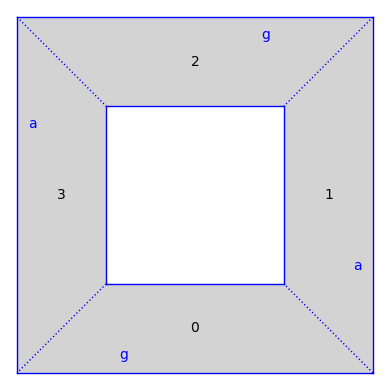

Dimensions: (1/2,2)
Square size: (1/2,1/2)
Rect size:   (1,2)
Previous queue not found.


/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/sage/rings/qqbar.py:2865: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  roots = p.roots(ring, False)


[  1   0]
[-12   1]

/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/zmq/sugar/attrsettr.py:51: RuntimeWarning: cypari2 leaked 11810834168 bytes on the PARI stack
  return self._get_attr_opt(upper_key, opt)


[-23/2  -7/2]
[ 63/2  19/2]

[ 17   8]
[-32 -15]

[ 19/4   7/4]
[-63/4 -23/4]

[ 19/2  -7/2]
[ 63/2 -23/2]

IDR 500/500 --> 72.31 seconds


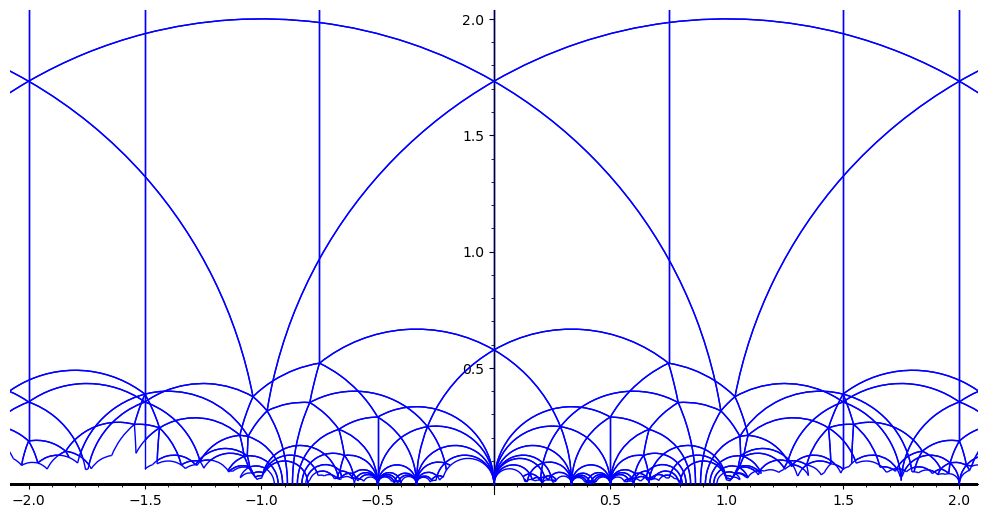

[
[ 19/2   7/2]  [ 17   8]  [-23/2  -7/2]  [ 19/2  -7/2]  [  1   0]
[-63/2 -23/2], [-32 -15], [ 63/2  19/2], [ 63/2 -23/2], [-12   1],

[-1  0]
[ 0 -1]
]

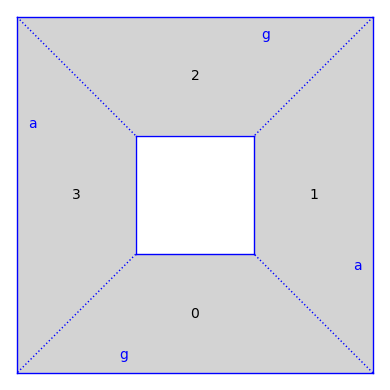

Dimensions: (1/3,2)
Square size: (1/3,1/3)
Rect size:   (1,2)
Previous queue not found.


[  1   0]
[-12   1]

IDR 500/500 --> 81.19 seconds


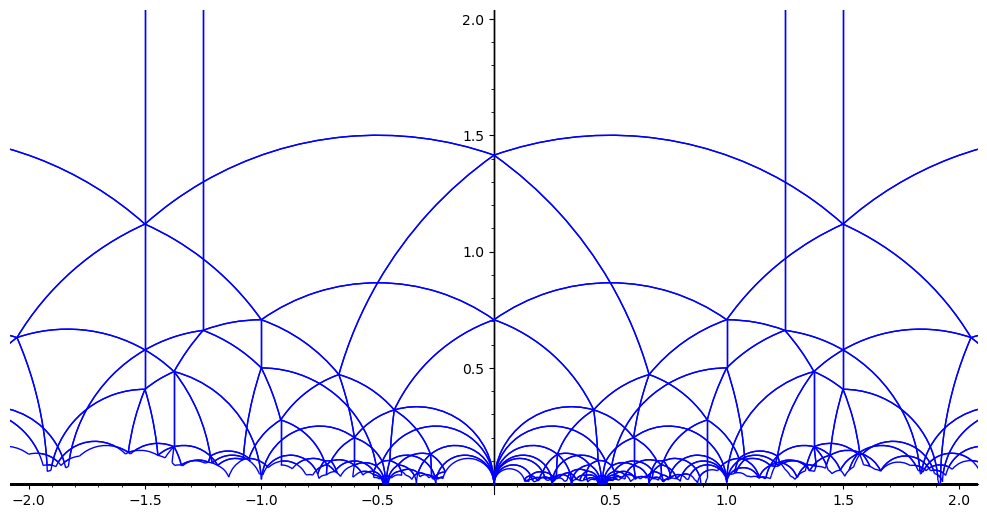

[
[  1   0]  [-1  0]
[-12   1], [ 0 -1]
]

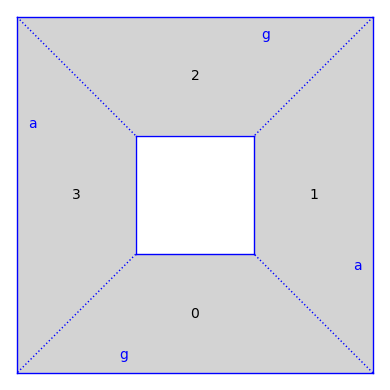

Dimensions: (1/3,3/2)
Square size: (1/3,1/3)
Rect size:   (1,3/2)
Previous queue not found.
IDR 500/500 --> 82.36 seconds


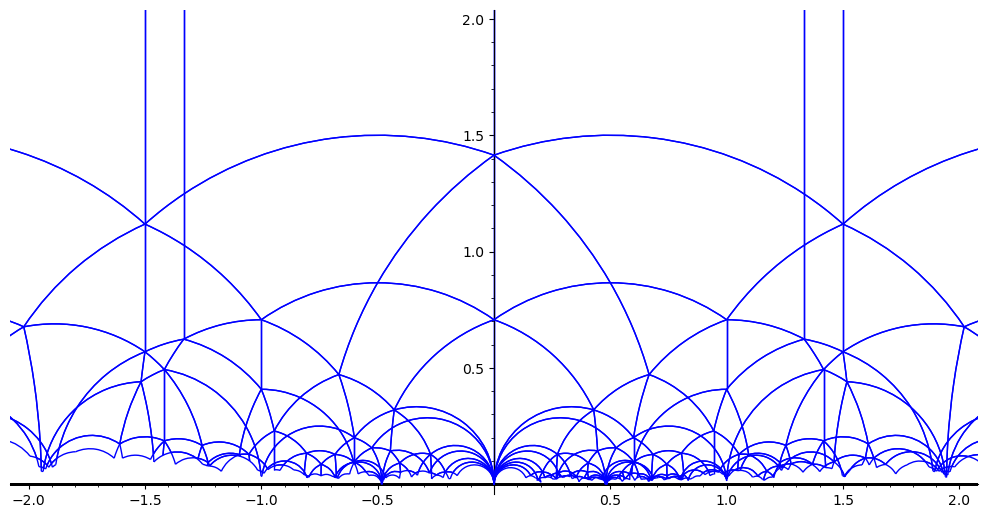

[
[-1  0]
[ 0 -1]
]

In [8]:
# Find Veech group of Dimple.

search_dimple(1/2,2)
search_dimple(1/3,2)
search_dimple(1/3,3/2)
